In [15]:
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

## Camera calibration, distortion and warping functions

In [12]:
def camera_calibration(img_size, verbose = False):
    
    # Number of corners in the checkboard
    nx = 9
    ny = 6

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if verbose:
            print('Calibration image ' + fname + ': ' + str(ret))

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (8,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)

            if verbose:
                f, ax = plt.subplots()
                ax.imshow(img)
    
    # Compute calibration coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Save for future use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )
    
    return mtx, dist


def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


def warp_image(img):
    
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    
    line_bottom_left = (200, 700)
    line_top_left = (590, 450)
    line_top_right = (img_size[0] - line_top_left[0], line_top_left[1])
    line_bottom_right = (img_size[0] - line_bottom_left[0], line_bottom_left[1])
    
    line_bottom_left_dst = (200, img_size[0])
    line_top_left_dst = (200, 0)
    line_top_right_dst = (img_size[0] - line_top_left_dst[0], line_top_left_dst[1])
    line_bottom_right_dst = (img_size[0] - line_bottom_left_dst[0], line_bottom_left_dst[1])
    
    src = np.float32([line_bottom_left,
                      line_top_left,
                      line_top_right,
                      line_bottom_right])
    
    dst = np.float32([line_bottom_left_dst,
                      line_top_left_dst,
                      line_top_right_dst,
                      line_bottom_right_dst])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

## Gradient processing

In [42]:
def gradient_magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros(scaled_sobel.shape)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output


def gradient_direction_threshold(img, sobel_kernel=3, thresh_deg=(0., 90.)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    
    # f, ax = plt.subplots(1, 1, figsize=(20,10))
    # ax.imshow(dir_sobel)
    
    thresh = (thresh_deg[0] / 180. * np.pi, thresh_deg[1] / 180. * np.pi)
    binary_output = np.zeros(dir_sobel.shape)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    
    return binary_output

## Color processing

In [87]:
def color_select(img, r_thresh=(0, 255), h_thresh=(0, 255), s_thresh=(0, 255)):
    
    # RGB channels
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    # HLS channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # It's the only one that makes sense, as lines are predominantly white or yellow, and G and B are
    # too influenced
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    # I'm trying it as it might be possible to isolate the hues specific of line colors
    h_binary = np.zeros_like(H)
    h_binary[(H > h_thresh[0]) & (H <= h_thresh[1])] = 1
    
    # Looks like to most robust
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1

    
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
    ax1.imshow(R, cmap='gray')
    ax2.imshow(r_binary, cmap='gray')
    
    ax3.imshow(H, cmap='gray')
    ax4.imshow(h_binary, cmap='gray')
    
    ax5.imshow(S, cmap='gray')
    ax6.imshow(s_binary, cmap='gray')

    return






## Use example

### Distortion and warping

In [3]:
filename = 'test_images/test1.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

mtx, dist = camera_calibration(img_size)

(1280, 720)


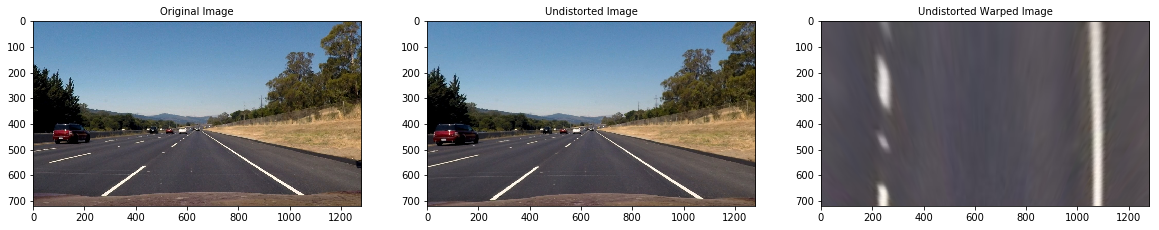

In [14]:
filename = 'test_images/straight_lines2.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = undistort_image(img, mtx, dist)
warped = warp_image(dst)

# cv2.imwrite('test_images/test_undist.jpg', dst)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
ax3.imshow(warped)
ax3.set_title('Undistorted Warped Image', fontsize=20)

### Gradient

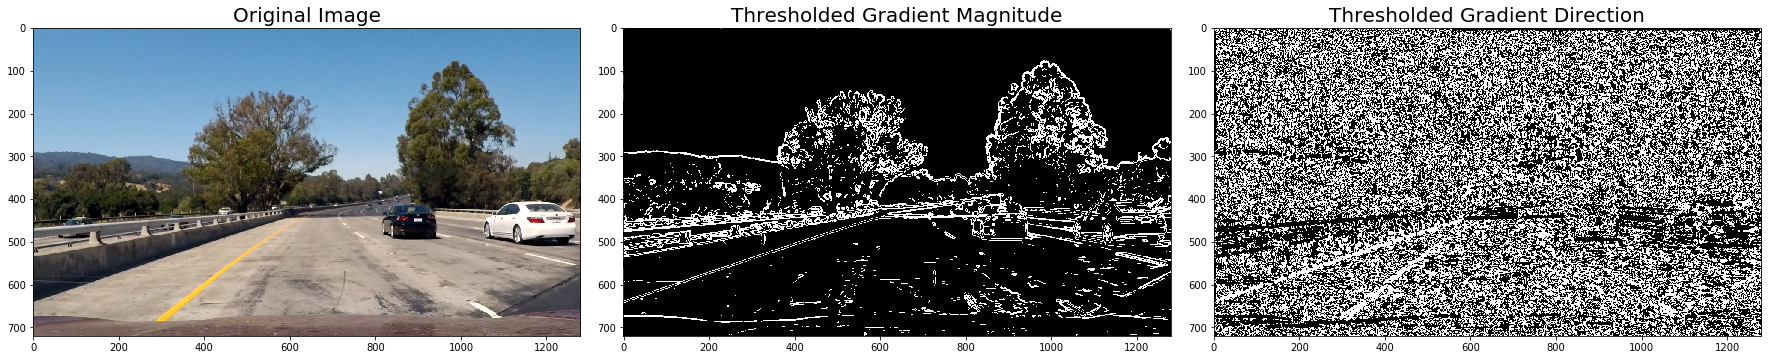

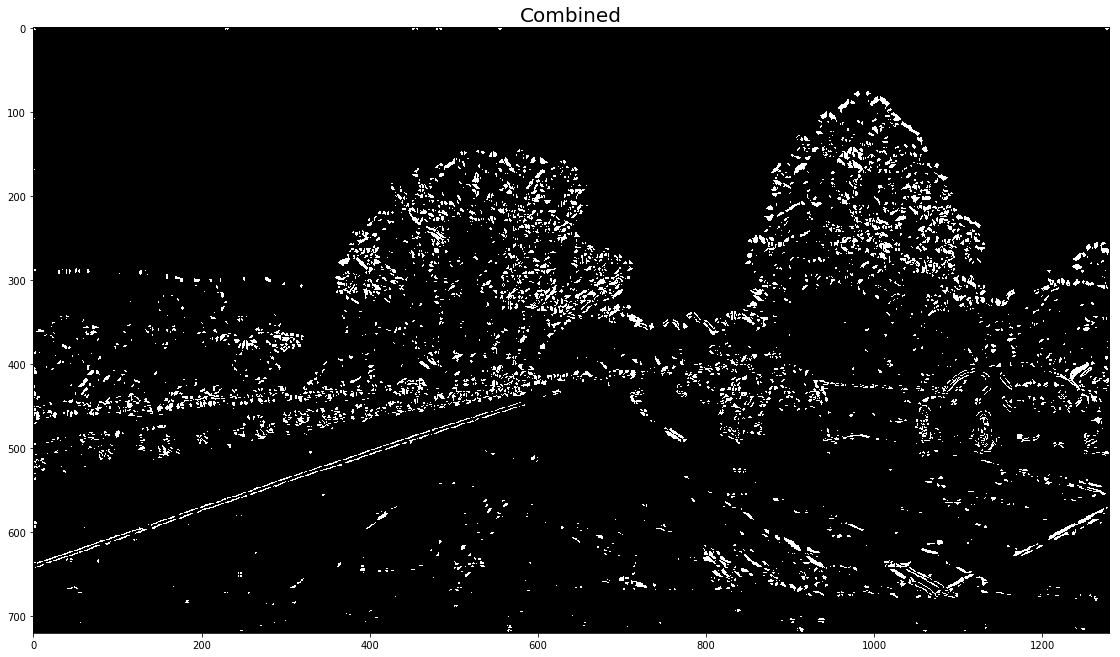

In [90]:
# filename = 'test_images/straight_lines1.jpg'
filename = 'test_images/test1.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mag_binary = gradient_magnitude_threshold(img, sobel_kernel=9, thresh=(30, 100))
dir_binary = gradient_direction_threshold(img, sobel_kernel=15, thresh_deg=(30., 75.))

combined = np.zeros_like(dir_binary)
combined[((mag_binary == 1) & (dir_binary == 1))] = 1



f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Magnitude', fontsize=20)
ax3.imshow(dir_binary, cmap='gray')
ax3.set_title('Thresholded Gradient Direction', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, ax = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax.imshow(combined, cmap='gray')
ax.set_title('Combined', fontsize=20)

### Colors

"\nf, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(img)\nax1.set_title('Original Image', fontsize=20)\nax2.imshow(mag_binary, cmap='gray')\nax2.set_title('Thresholded Gradient Magnitude', fontsize=20)\nax3.imshow(dir_binary, cmap='gray')\nax3.set_title('Thresholded Gradient Direction', fontsize=20)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n\n\nf, ax = plt.subplots(1, 1, figsize=(24, 9))\nf.tight_layout()\nax.imshow(combined, cmap='gray')\nax.set_title('Combined', fontsize=20)\n"

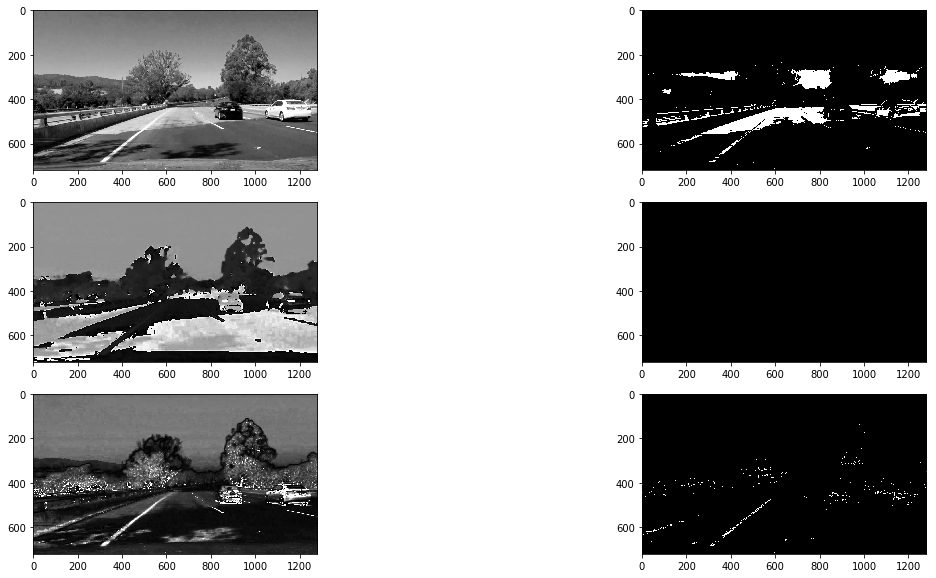

In [101]:
# filename = 'test_images/straight_lines2.jpg'
filename = 'test_images/test4.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

color_select(img, r_thresh=(180,250), s_thresh=(180,250), h_thresh=(200,255))

"""
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Magnitude', fontsize=20)
ax3.imshow(dir_binary, cmap='gray')
ax3.set_title('Thresholded Gradient Direction', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, ax = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax.imshow(combined, cmap='gray')
ax.set_title('Combined', fontsize=20)
"""

